In [1]:
import numpy as np
import pandas as pd
import joblib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
train_df = pd.read_csv('./data/fl_2022_LastName_train.csv.gz')
val_df = pd.read_csv('./data/fl_2022_LastName_val.csv.gz')
test_df = pd.read_csv('./data/fl_2022_LastName_test.csv.gz')

In [3]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(845316, 9)
(105664, 9)
(105665, 9)


In [5]:
train_df.head()

,name_last,asian,hispanic,nh_black,nh_white,other,total_n,race,race_code
0,Neaman-Piotrowicz,0.0,0.0,0.0,1.000000,0.000000,1.0,nh_white,3
1,Chaet,0.0,0.0,0.0,1.000000,0.000000,13.0,nh_white,3
2,Veloz Perez,0.0,1.0,0.0,0.000000,0.000000,1.0,hispanic,1
3,Spalter,0.0,0.0,0.0,0.928571,0.071429,42.0,nh_white,3
4,Kearns-Edwards,0.0,0.0,0.0,1.000000,0.000000,1.0,nh_white,3


In [8]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Extract features

In [14]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), min_df=50, lowercase=False)

In [15]:
X_train = vectorizer.fit_transform(train_df['name_last'])
X_val = vectorizer.transform(val_df['name_last'])
X_test = vectorizer.transform(test_df['name_last'])

In [16]:
X_train.shape

(845316, 1066)

In [17]:
X_val.shape

(105664, 1066)

In [18]:
X_test.shape

(105664, 1066)

In [19]:
vectorizer.get_feature_names_out()

array([' ', ' -', ' A', ..., 'zw', 'zy', 'zz'], dtype=object)

In [20]:
len(vectorizer.get_feature_names_out())

1066

In [21]:
vocab = vectorizer.get_feature_names_out()

In [22]:
y_train = train_df.race_code
y_val = val_df.race_code
y_test = test_df.race_code

In [23]:
y_train[0]

3

In [24]:
#Create a Gaussian Classifier
clf = GradientBoostingClassifier(random_state=42, verbose=6)

In [25]:
print(X_train.shape)
print(X_test.shape)

(845316, 1066)
(105664, 1066)


## Training

In [26]:
%%time

clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0800           45.62m
         2           1.0353           44.42m
         3           1.0013           43.02m
         4           0.9740           42.85m
         5           0.9522           42.14m
         6           0.9347           41.34m
         7           0.9200           40.73m
         8           0.9072           40.11m
         9           0.8967           39.60m
        10           0.8871           38.93m
        11           0.8788           38.26m
        12           0.8713           37.97m
        13           0.8651           37.42m
        14           0.8585           36.91m
        15           0.8531           36.45m
        16           0.8482           36.06m
        17           0.8439           35.47m
        18           0.8393           34.98m
        19           0.8356           34.45m
        20           0.8319           33.93m
        21           0.8291           33.50m
        2

GradientBoostingClassifier(random_state=42, verbose=6)

In [27]:
%%time
y_pred = clf.predict(X_val)
# Model Accuracy, how often is the classifier correct?
print("Val Accuracy:", metrics.accuracy_score(y_val, y_pred))

Val Accuracy: 0.7558392640823743
CPU times: user 1.18 s, sys: 46.8 ms, total: 1.22 s
Wall time: 1.39 s


In [28]:
%%time
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.7545710932768019
CPU times: user 1.22 s, sys: 44.7 ms, total: 1.26 s
Wall time: 1.43 s


In [29]:
joblib.dump(vectorizer, "models/gb_vec_lastname.joblib", compress=3)  # compression is ON!

['models/gb_vec_lastname.joblib']

In [30]:
joblib.dump(clf, "models/gb_model_lastname.joblib", compress=3)  # compression is ON!

['models/gb_model_lastname.joblib']

## Confusion Matrix

In [31]:
race_id_df = train_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)

In [32]:
race_to_id

{'asian': 0, 'hispanic': 1, 'nh_black': 2, 'nh_white': 3, 'other': 4}

In [33]:
id_to_race = dict(race_id_df[['race_code', 'race']].values)

In [34]:
id_to_race

{0: 'asian', 1: 'hispanic', 2: 'nh_black', 3: 'nh_white', 4: 'other'}

              precision    recall  f1-score   support

       asian       0.67      0.07      0.13      3648
    hispanic       0.83      0.80      0.81     32461
    nh_black       0.64      0.12      0.20     10403
    nh_white       0.73      0.93      0.81     56262
       other       0.34      0.01      0.01      2890

    accuracy                           0.75    105664
   macro avg       0.64      0.39      0.40    105664
weighted avg       0.74      0.75      0.71    105664



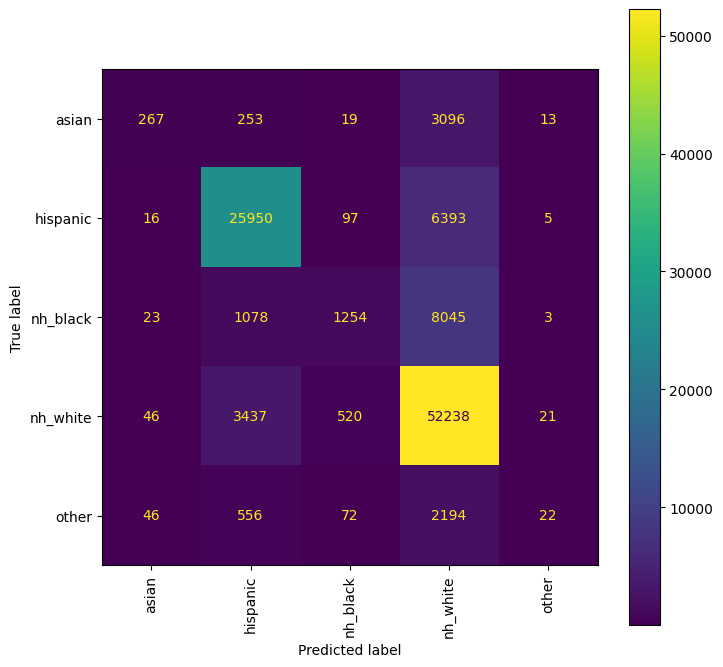

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline  

model = joblib.load('models/gb_model_lastname.joblib')
preds = model.predict(X_test)
predicted = [id_to_race[p] for p in preds]
actual = [id_to_race[p] for p in y_test.values]

print(classification_report(actual, predicted))

cm = confusion_matrix(actual, predicted, labels=list(race_to_id.keys()))
cmp = ConfusionMatrixDisplay(cm, display_labels=list(race_to_id.keys()))
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [36]:
for class_id in id_to_race:
    correct = np.sum((y_test == class_id) & (preds == class_id))
    total = np.sum(y_test == class_id)
    print(f'Accuracy for class {id_to_race[class_id]}: {correct / total:.2f}')

Accuracy for class asian: 0.07
Accuracy for class hispanic: 0.80
Accuracy for class nh_black: 0.12
Accuracy for class nh_white: 0.93
Accuracy for class other: 0.01
